<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [72]:
# ANSWER
titanic_csv = 'data/train.csv'
titanic = pd.read_csv(titanic_csv, index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [73]:
# ANSWER
# First, check shape and data types
print(titanic.shape, '\n')
titanic.dtypes

(891, 11) 



Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [74]:
# Check null values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [75]:
# Have to deal with Age, Cabin, and Embarked, as below:
# Replace Null values in Age with the mean age in order to minimise effects to the age distribution
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)

# Null values in Cabin column make up large majority of data - best to just prune the entire column
titanic = titanic.drop('Cabin', axis=1)

# Embarked location is categorical data, so use mode to preserve statistics
# Backfill NaN values
embarked_mode = titanic['Embarked'].mode()[0]

titanic['Embarked'].fillna(embarked_mode, inplace=True)

# Verify
titanic.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [76]:
# Convert Sex to binary data
titanic.Sex = titanic.Sex == 'male'

# Verify
titanic.dtypes

Survived      int64
Pclass        int64
Name         object
Sex            bool
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Embarked     object
dtype: object

In [77]:
# Convert Embarked to binary data through dummy columns
embarked = pd.get_dummies(titanic.Embarked, prefix='Embark')
titanic = titanic.join(embarked)
titanic.drop('Embarked', axis=1, inplace=True)
titanic.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embark_C,Embark_Q,Embark_S
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,A/5 21171,7.2500,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,PC 17599,71.2833,1,0,0
3,1,3,"Heikkinen, Miss. Laina",False,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,35.0,1,0,113803,53.1000,0,0,1
5,0,3,"Allen, Mr. William Henry",True,35.0,0,0,373450,8.0500,0,0,1


In [78]:
# Features that definitely won't help with prediction: Name, Ticket
titanic.drop(['Name', 'Ticket'], axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embark_C,Embark_Q,Embark_S
PassengerId,,,,,,,,,,
1,0,3,True,22.0,1,0,7.2500,0,0,1
2,1,1,False,38.0,1,0,71.2833,1,0,0
3,1,3,False,26.0,0,0,7.9250,0,0,1
4,1,1,False,35.0,1,0,53.1000,0,0,1
5,0,3,True,35.0,0,0,8.0500,0,0,1


In [79]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embark_C,Embark_Q,Embark_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [80]:
# ANSWER
X = titanic[['Pclass', 'Parch']]
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [81]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)


#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [82]:
# ANSWER
# Create Model
logreg = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [83]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [84]:
# ANSWER
logreg.coef_


array([[-1.752352  ,  1.45655229]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [85]:
# ANSWER
logreg.intercept_[0]

0.4980162851832834

We can create tuples of the predictor names and coefficients like this:

In [86]:
# ANSWER
print(set(zip(X.columns, logreg.coef_[0])))

{('Parch', 1.4565522931877701), ('Pclass', -1.7523520048178354)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [87]:
for col in zip(X.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -1.752352
Parch       +1.456552


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [88]:
# ANSWER
logreg.score(X_train, y_train)

0.6966292134831461

What is the  `accuracy_score` for the test data?

In [89]:
# ANSWER
logreg.score(X_test, y_test)

0.6703910614525139

What can we say aout this result?

ANSWER
- Just with these two variables, a reasonable accuracy score of 0.67 for the test data was achieved. They clearly heavily influence the Survival rate
- The Test and Training data returned very similar accuracy scores, validating the model

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [90]:
# ANSWER
# Age null values already dealt with above

In [91]:
# Build Model
X = titanic[['Pclass', 'Parch', 'Age']]
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)

# Fit Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Score
logreg.score(X_test, y_test)

0.6871508379888268

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- The two previous variables might have a much greater influence on survival rate than age
- It is also possible that there is a great deal of colinearity between Age and one or both of the other variables, which would reduce it's usefulness in combination with them

Let's see where the model is going wrong by showing the Confusion Matrix:

In [92]:
# ANSWER
from sklearn import metrics
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[92 14]
 [42 31]]


Nb. Here is how `confusion_matrix` arranges its output:

In [93]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: False Negatives (FN) are three times more prominent than False Positives (FP). However, the proportions of TN/FN and TP/FP are very similar, so for every True assignation, the model produces the same amount of False assignations.

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

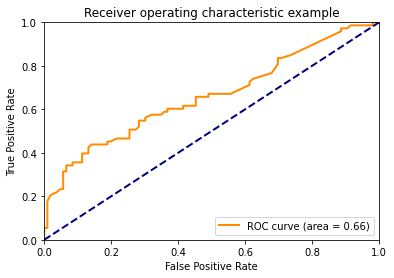

In [94]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [95]:
# Already performed in EDA with Sex and Embarked.
# Will do for Pclass

titanic_with_dummies = pd.get_dummies(titanic.Pclass, 
                                      prefix = 'Pclass')
titanic = titanic.join(titanic_with_dummies).drop('Pclass', axis=1)
titanic.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embark_C,Embark_Q,Embark_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,
1,0,True,22.0,1,0,7.2500,0,0,1,0,0,1
2,1,False,38.0,1,0,71.2833,1,0,0,1,0,0
3,1,False,26.0,0,0,7.9250,0,0,1,0,0,1
4,1,False,35.0,1,0,53.1000,0,0,1,1,0,0
5,0,True,35.0,0,0,8.0500,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [96]:
# Return null values to Age column
titanic_old = pd.read_csv(titanic_csv, index_col='PassengerId')
titanic['Age'] = titanic_old['Age']

# Impute Age with stratification
titanic['Age'] = titanic[["Age", "Parch", "Sex", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [97]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Build Model
X = titanic[['Pclass_1', 'Pclass_2', 'Parch', 'Age', 'Embark_C', 'Embark_Q', 'Sex']]
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)

# Fit Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Score
logreg.score(X_test, y_test)

0.776536312849162

Plot the ROC curve for the new model:

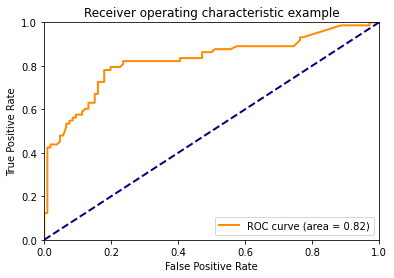

In [98]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [99]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Build Model
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)

# Fit Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Score
logreg.score(X_test, y_test)

0.7988826815642458

The model shows a very marginal improvement with the addition of the remaining data

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

### 1.

In [100]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Build Model
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

# Create for loop for multiple iterations
score = []

for i in range(0,5):
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2)

    # Fit Model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    # Score
    score.append(logreg.score(X_test, y_test))

score

[0.8044692737430168,
 0.7988826815642458,
 0.8491620111731844,
 0.776536312849162,
 0.7877094972067039]

The final accuracy score varies by a significant amount for different random states.

### 2.

In [101]:
# Set Feature Both Numerical, Categorical
# Build Model
X = titanic[['Pclass_1', 'Pclass_2', 'Parch', 'Age', 'Embark_C', 'Embark_Q', 'Sex']]
y = titanic['Survived']

# Scale Features
from sklearn.preprocessing import MinMaxScaler
X_scale = MinMaxScaler().fit_transform(X)

# Call model
logreg = LogisticRegression()

# Call cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(logreg, X=X_scale, y=y)

final_score = np.mean(cross_val_score(logreg, X=X_scale, y=y))

final_score


0.7901324461741259

Average accuracy does improve

### 3.

In [102]:
# In TPR(True Positive Rate) vs FPR(False Positive Rate), 
# the question is whether the priority is on maximising capture of true positives,
# or on eliminating true negatives (and as a result minimizing false positives)

# In this case, will optimise based off maximising the distance to the centreline
# D = sqrt((y-tpr)^2 + (y-fpr)^2)
# D' = (-a-b+2y)/sqrt(a^2 - 2ay + b^2 - 2by + 2y^2)
# for D' = 0:
# y = (tpr + fpr)/2

# So:
D = np.sqrt(((fpr-tpr)/2)**2 + ((tpr-fpr)/2)**2)
max_D_pos = np.argmax(D)
optimal_threshold = thresholds[max_D_pos]

print("The threshold value that provides the optimal payoff between TPR and FPR is", optimal_threshold)


The threshold value that provides the optimal payoff between TPR and FPR is 0.4289174850335281




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



